<img width="50" src="https://carbonplan-assets.s3.amazonaws.com/monogram/dark-small.png" style="margin-left:0px;margin-top:20px"/>

# Buffer Pool Analysis

_by Grayson Badgley, September 17, 2020_

This notebook performs analysis of ...

## Methodology

...

## References

...

- Data: https://ww3.arb.ca.gov/cc/capandtrade/offsets/issuance/arboc_issuance.xlsx

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns

### Load data

In [5]:
df = pd.read_excel('https://carbonplan.blob.core.windows.net/carbonplan-articles/offset-project-fire/arboc_issuance.xlsx', sheet_name=3)
display(df.head())

,CARB Issuance ID,OPR Project ID,Project Type,Early Action/ Compliance,Reporting Period Start Date,Reporting Period End Date,Vintage,ARB Offset Credits Issued,Forest Buffer Account Contribution,Issuance Date,...,State,Provides DEBS,"Section 95989(b) Documentation, if applicable",Project Documentation,Retired Voluntarily,Retired 1st Compliance Period (CA),Retired 2nd Compliance Period (CA),Retired 3rd Compliance Period (CA),Retired for Compliance in Quebec,Comment
0,CAOD5001-A,CAR992,ODS,COP,2013-01-24,2013-02-01,2013.0,107542,NaN,2013-10-22,...,AR,–,–,https://thereserve2.apx.com/mymodule/reg/prjVi...,0,107542,0,0,0,For the second verification (to reduce the inv...
1,CAOD5002-A,ACR170,ODS,COP,2012-03-28,2012-09-23,2012.0,306517,NaN,2013-09-23,...,AR,–,–,https://acr2.apx.com/mymodule/reg/prjView.asp?...,0,134808,171709,0,0,NaN
2,CAFR5003-A,CAR973,Forest,COP,2012-08-08,2013-06-23,2013.0,2163951,415479,2014-06-10,...,MI,–,–,https://thereserve2.apx.com/mymodule/reg/prjVi...,0,817980,802319,124214,0,"On 9/12/2017, ARB retired 178,642 of 415,479 c..."
3,CAFR5003-B,CAR973,Forest,COP,2013-06-24,2014-06-23,2014.0,147666,28352,2015-09-08,...,MI,–,–,https://thereserve2.apx.com/mymodule/reg/prjVi...,0,84000,31207,4107,0,NaN
4,CAFR5003-C,CAR973,Forest,COP,2014-06-24,2015-06-23,2015.0,349786,67159,2016-09-27,...,MI,–,–,https://thereserve2.apx.com/mymodule/reg/prjVi...,0,0,191314,0,91313,NaN


## Cleaning the data

Looks like two of the the Forest projects are reforestation and have "Forest Buffer Contributions" of "reforest defer" -- they haven't been issued any credits so lets exclude them from the rest of the analysis.

It also looks like one project has received zero credits -- let's just remove that to be conservative. 

Then we cut things down to just forests, because we want to understand those projects and their relationship to the *forest* buffer pool.

In [6]:
df[df['Forest Buffer Account Contribution'].apply(lambda x : isinstance(x, str))]

,CARB Issuance ID,OPR Project ID,Project Type,Early Action/ Compliance,Reporting Period Start Date,Reporting Period End Date,Vintage,ARB Offset Credits Issued,Forest Buffer Account Contribution,Issuance Date,...,State,Provides DEBS,"Section 95989(b) Documentation, if applicable",Project Documentation,Retired Voluntarily,Retired 1st Compliance Period (CA),Retired 2nd Compliance Period (CA),Retired 3rd Compliance Period (CA),Retired for Compliance in Quebec,Comment
387,CAFR5165-(reforest defer),CAR1165,Forest,COP,2015-12-31,2017-12-30,NaN,reforest defer,reforest defer,NaT,...,CA,DEBS,–,https://thereserve2.apx.com/mymodule/reg/prjVi...,0,0,0,0,0,CARB approved first full verification on 4/21/...
388,CAFR5167-(reforest defer),CAR1167,Forest,COP,2015-12-31,2017-12-30,NaN,reforest defer,reforest defer,NaT,...,CA,DEBS,–,https://thereserve2.apx.com/mymodule/reg/prjVi...,0,0,0,0,0,CARB approved first full verification on 4/21/...


In [7]:
df = df[~df['Forest Buffer Account Contribution'].apply(lambda x : isinstance(x, str))]
df = df[df['ARB Offset Credits Issued'] > 0]
forest_df = df[df['Project Type'] == 'Forest']

Both EA and COP contriubte to buffer pool, we'll consider both

In [8]:
forest_df.groupby('Early Action/ Compliance')['Forest Buffer Account Contribution'].sum()

Early Action/ Compliance
COP    23204213
EA      2581159
Name: Forest Buffer Account Contribution, dtype: int64

There are 127 total forest projects that have ever been issued credits

In [9]:
n_projects = forest_df['OPR Project ID'].nunique()
n_projects

127

## ACR260/CAFR5214

Has been issued credits three times, though it has applied for them four times. The ARB excel file notes that the reporting period starting 2016-09-27 was 
I confirmed that the reporting period start and end date match the Annual OPDRs from the ACR web portal: https://acr2.apx.com/mymodule/reg/TabDocuments.asp?r=111&ad=Prpt&act=update&type=PRO&aProj=pub&tablename=doc&id1=260.

In [10]:
proj_id = 'ACR260'
forest_df[forest_df['OPR Project ID'] == proj_id]

,CARB Issuance ID,OPR Project ID,Project Type,Early Action/ Compliance,Reporting Period Start Date,Reporting Period End Date,Vintage,ARB Offset Credits Issued,Forest Buffer Account Contribution,Issuance Date,...,State,Provides DEBS,"Section 95989(b) Documentation, if applicable",Project Documentation,Retired Voluntarily,Retired 1st Compliance Period (CA),Retired 2nd Compliance Period (CA),Retired 3rd Compliance Period (CA),Retired for Compliance in Quebec,Comment
481,CAFR5214-A,ACR260,Forest,COP,2014-12-05,2015-09-27,2015.0,2154371,341159,2018-08-07,...,OR,–,–,https://acr2.apx.com/mymodule/reg/prjView.asp?...,0,0,0,0,0,NaN
482,CAFR5214-B,ACR260,Forest,COP,2015-09-28,2016-09-27,2016.0,390155,61784,2020-01-14,...,OR,–,–,https://acr2.apx.com/mymodule/reg/prjView.asp?...,0,0,0,0,0,NaN
484,CAFR5214-C,ACR260,Forest,COP,2017-09-28,2018-09-27,2018.0,131957,20896,2020-01-14,...,OR,–,–,https://acr2.apx.com/mymodule/reg/prjView.asp?...,0,0,0,0,0,NaN


## How big is this project?

In the scheme of things, this is a pretty big project -- it's the 15th of 128 projects in the CARB issuance database. 
It's also the largest in Oregon.

In [11]:
total_credits = forest_df['ARB Offset Credits Issued'].sum()
per_proj_credits = forest_df.groupby('OPR Project ID')['ARB Offset Credits Issued'].sum()
perc_credits = per_proj_credits/total_credits * 100

proj_state_map = forest_df.groupby('OPR Project ID').State.max().to_dict() # max() makes 1:1 mapping of opr_id to state
perc_credits = perc_credits.sort_values(ascending=False).to_frame()
perc_credits['state'] = perc_credits.index.map(proj_state_map)
perc_credits = perc_credits.rename(columns={'ARB Offset Credits Issued': "Percent Forest ARB Offset Credits Issued"})

proj_loc = perc_credits.index.get_loc(proj_id)
perc_credits[:proj_loc+1] # +1 to include ACR16, otherwise off by one

,Percent Forest ARB Offset Credits Issued,state
OPR Project ID,,
ACR360,9.902237,AK
ACR255,9.199629,WA
ACR324,7.562175,AK
CAR1264,4.577290,AK
ACR303,3.847541,AZ
ACR211,3.147577,AZ
ACR249,3.053140,WV
CAR1183,2.830198,NM
CAR1175,2.801494,ME


In [12]:
total_buffer_pool = forest_df['Forest Buffer Account Contribution'].sum()

In [13]:
total_buffer_pool

25785372

In [14]:
proj_credits = forest_df[forest_df['OPR Project ID'] == proj_id]['ARB Offset Credits Issued'].sum()
proj_credits

2676483

In [15]:
proj_credits/total_buffer_pool

0.10379850249978942

In [18]:
frac_buffer = 0.107
frac_burned = 0.8
prob_mortality = 0.25
freq_burn = 0.50
arr  = np.random.binomial(size=(1000,100), n=1, p=freq_burn) * frac_buffer * frac_burned * prob_mortality
#ser[ser > 1] = 1

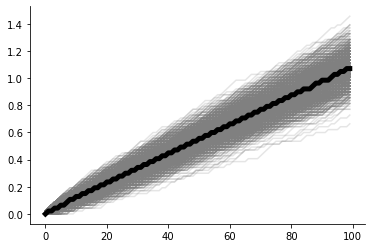

In [19]:
g = pd.DataFrame(arr.cumsum(axis=1)).T.plot(color='grey', alpha=0.2, legend=False)
med_case = np.median(arr.cumsum(axis=1), axis=0)
g.plot(np.arange(100), med_case, lw=5, c='k')
sns.despine()

In [22]:
forest_df['buffer_contrib'] = forest_df['Forest Buffer Account Contribution']/forest_df['ARB Offset Credits Issued']

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [225]:
# for understanding fire contribution, lets get rid of ea, since have some funky high values
cop_forest = forest_df[forest_df['Early Action/ Compliance'] == 'COP']

In [226]:
(((0.5 * 2 + 0.5*4)/100)/cop_forest['buffer_contrib'].astype(float)).median()

0.15624930320312166

In [227]:
(0.04/cop_forest['buffer_contrib'].astype(float)).median()

0.20833240427082889